In [23]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [53]:
data_low=torch.load("E:\Workspaces\Diffusicity_estimation_2\Anisotropic_diffusivity_2\diffusivity_ensamble_estimation_10xlower.pth")
data_high=torch.load("E:\Workspaces\Diffusicity_estimation_2\Anisotropic_diffusivity_2\diffusivity_ensamble_estimation_10xhighier.pth")
data_mid=torch.load("E:\Workspaces\Diffusicity_estimation_2\Anisotropic_diffusivity_2\diffusivity_ensamble_estimation_on_point.pth")

In [25]:
data = np.load(r'F:\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz', allow_pickle=True)

In [26]:
data['meta']

array([['time', '28/10/2025 11:07:19'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [40]:
# Diffusivity estimation m^2/s
a=2/(700*1600)
a
target_a=a*1e3
target_a

0.0017857142857142857

In [28]:
data['data'].shape

(334, 512, 512)

Text(0.5, 1.0, 'Surface temperature evolution')

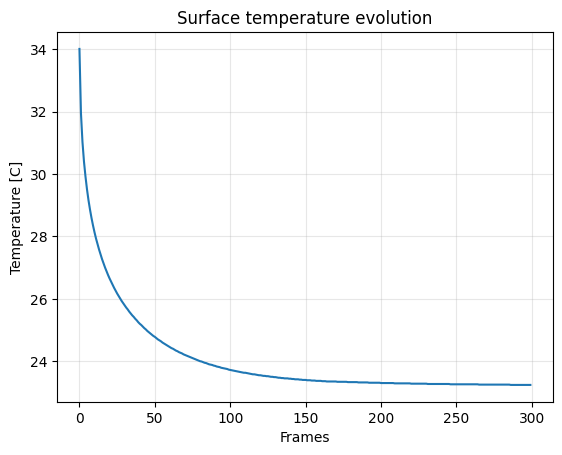

In [29]:
plt.plot(data['data'][34:,256,256])
plt.xlabel('Frames')
plt.ylabel('Temperature [C]')
plt.grid(alpha=0.3)
plt.title("Surface temperature evolution")

Text(0.5, 1.0, 'Surface temperature evolution')

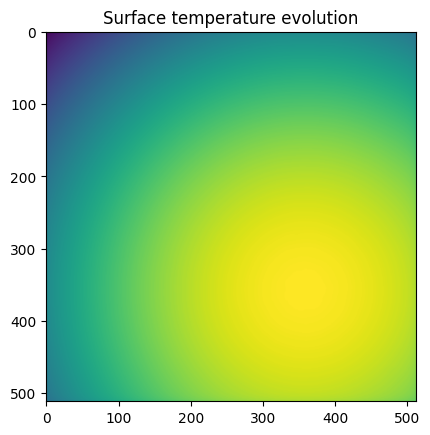

In [30]:
plt.imshow(data['data'][34,:,:])
plt.title("Surface temperature evolution")

In [62]:
data_low=torch.from_numpy(np.array(data_low)).to(torch.float32)


In [63]:
data_high=torch.from_numpy(np.array(data_high)).to(torch.float32)

In [38]:
data_high.std()

tensor(0.0012)

In [50]:
error_low=torch.abs((target_a-data_high.median()))/target_a*100
error_low

tensor(521.5296)

In [51]:
CV_low=data_low.std()/data_low.mean()
CV_low

tensor(0.4689)

In [52]:
CV_high=data_high.std()/data_high.mean()
CV_high

tensor(0.1081)

In [54]:
data_mid=torch.from_numpy(np.array(data_mid)).to(torch.float32)

In [58]:
data_mid.std()/data_mid.mean()

tensor(0.4264)

In [60]:
error_mid=torch.abs((target_a-data_mid.median()))/target_a*100
error_mid

tensor(21.3822)

In [65]:
(data_mid.median()+data_low.median()+data_high.median())/3

tensor(0.0049)